Không sử dụng tập test, dùng tập train để train và test

## Import the libraries

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split    

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Dataloader

In [2]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

## Transformer

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

## File paths

In [12]:
train_1 = "../data/train_FD004.txt"
test_1 = "../data/test_FD004.txt"
rul_1 = "../data/RUL_FD004.txt"

## Tính toán RUL cho train

In [5]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train = pd.read_csv(train_1, sep=' ', header=None)
train.drop([26, 27], axis=1, inplace=True)
train.columns = column_names

train['Remaining RUL'] = ''
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,


In [6]:
max_cycle = train.groupby('ID Engine').count()

for idx in range(len(train)):
    train.loc[idx, 'Remaining RUL'] = max_cycle.loc[train.loc[idx, 'ID Engine'], 'Cycle']

train['Remaining RUL'] = train['Remaining RUL'] - train['Cycle']

In [7]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [8]:
train.shape
# Có đầy đủ 27 features ban đầu

(61249, 27)

## Load RUL

In [9]:
rul = pd.read_csv(rul_1, sep=' ', header=None)
rul.drop(rul.columns[1], axis=1, inplace=True)
rul.columns = ['RUL']
rul.head()

,RUL
0,22
1,39
2,107
3,75
4,149


## Tính toán RUL cho test

In [13]:
test = pd.read_csv(test_1, sep=' ', header=None)
test.drop([26, 27], axis=1, inplace=True)
test.columns = column_names

test['Remaining RUL'] = ''
test.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,


In [14]:
max_cycle_test = test.groupby('ID Engine').count()
max_cycle_test['Cycle'].head()

ID Engine
1    230
2    153
3    141
4    208
5     51
Name: Cycle, dtype: int64

In [15]:
rul.head()

,RUL
0,22
1,39
2,107
3,75
4,149


In [16]:
# Công thức tính toán RUL cho test có thể là:
# RUL cuối cùng (trong tập testtest) + Cycles đã trải qua - cột Cycle tương ứng
for idx in range(len(test)):
    test.loc[idx, 'Remaining RUL'] = rul.loc[test.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test.loc[test.loc[idx, 'ID Engine'], 'Cycle']

test['Remaining RUL'] = test['Remaining RUL'] - test['Cycle']

In [17]:
test.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247


In [18]:
# Trong tập test, động cơ có số lượng vòng đời được chạy ít nhất là ID Engine = 1 với số vòng đời trong tập test là 31 dòng
test.groupby('ID Engine').count().min()[0]

np.int64(19)

## Standard data (train and test)

In [19]:
# Bỏ đi các cột setting sẽ không chuẩn hóa
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [20]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,0.000000,0.130347,0.272082,0.212586,0.000000,...,0.993111,0.550773,0.400540,0.0,0.288660,0.627907,1.0,0.015473,0.015881,0.590406
1,1,2,20.0020,0.7002,100.0,0.626985,0.647971,0.634407,0.511781,0.507937,...,0.992395,0.481761,0.351346,0.0,0.608247,0.864693,1.0,0.477968,0.481487,0.588561
2,1,3,42.0038,0.8409,100.0,0.000000,0.123646,0.271245,0.222481,0.000000,...,0.993056,0.531031,0.423787,0.0,0.278351,0.627907,1.0,0.010764,0.018932,0.586716
3,1,4,42.0000,0.8400,100.0,0.000000,0.121351,0.266168,0.224835,0.000000,...,0.993194,0.553707,0.401716,0.0,0.268041,0.627907,1.0,0.012782,0.018724,0.584871
4,1,5,25.0063,0.6207,60.0,0.238089,0.005691,0.033916,0.022025,0.293184,...,0.001405,0.048140,0.920536,0.0,0.030928,0.000000,0.0,0.130172,0.145560,0.583026


In [21]:
# test.head()

## Load data

In [22]:
sequence_length = 30
batch_size = 64
epochs = 50
input_dim = 21 # Frome sensor 1 to sensor 21

In [23]:
data_train = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
# data_test = CMAPSSLoaderDataset(test, sequence_length=sequence_length)

train_data, validation_data = train_test_split(data_train, test_size=0.2, random_state=42)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
# validation_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [24]:
data_train.__len__()

54028

In [25]:
train_data.__len__()

43222

In [26]:
validation_data.__len__()

10806

In [27]:
train_loader.__len__()

845

In [28]:
validation_loader.__len__()

169

In [29]:
batch = next(iter(train_loader))
# print(batch)
seq, target = batch

# print(f'seq={seq}, shape={seq.shape}')
# print(f'target={target}, shape={target.shape}')

## Training model

In [30]:
def train(model, train_loader, validation_loader, epochs=epochs, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for batch in train_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)

            optimizer.zero_grad() # Reset gradient.
            output = model(seq) # Tính dự đoán từ mô hình.
            loss = criterion(output, target) # Tính giá trị mất mát giữa dự đoán và nhãn thật.
            loss.backward() # Tính gradient của mất mát.
            optimizer.step() # Cập nhật tham số mô hình dựa trên gradient.
            train_loss += loss.item() # Ghi nhận giá trị mất mát
        
        # Evaluate
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in validation_loader:
                seq, target = batch
                seq, target = seq.to(device), target.to(device)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(validation_loader)}")

In [31]:
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
train(model=model, train_loader=train_loader, validation_loader=validation_loader, epochs=epochs)

Epoch 1: Train Loss = 0.034817508648882604, Val Loss = 0.015624588967119095
Epoch 2: Train Loss = 0.017229622472408255, Val Loss = 0.012449193183751501
Epoch 3: Train Loss = 0.014360070468846863, Val Loss = 0.011622143294882668
Epoch 4: Train Loss = 0.01310029538326274, Val Loss = 0.01268911301351246
Epoch 5: Train Loss = 0.012613708747980686, Val Loss = 0.011167352911658011
Epoch 6: Train Loss = 0.012226242963885943, Val Loss = 0.011419284416461837
Epoch 7: Train Loss = 0.012123726553024626, Val Loss = 0.011376392595007046
Epoch 8: Train Loss = 0.011843020751102436, Val Loss = 0.011651722064032357
Epoch 9: Train Loss = 0.011777598118773226, Val Loss = 0.01091064794330731
Epoch 10: Train Loss = 0.011632148014414593, Val Loss = 0.011114668539179676
Epoch 11: Train Loss = 0.011555283281886014, Val Loss = 0.01155404008087322
Epoch 12: Train Loss = 0.011382562091254447, Val Loss = 0.0107044857050452
Epoch 13: Train Loss = 0.011225972591882802, Val Loss = 0.011051372641466073
Epoch 14: Trai

## Evaluate model

## Predict on a batch

In [32]:
len(validation_loader)

169

actual_predictions: [169.3487516    6.02469123  55.34622785  18.70090355 247.76870012
 267.70946884   0.96074983 158.89875656 178.17010236 151.54413384
  39.09588258 188.90561533 205.51241785 135.46850193 128.85596576
 223.70606107 102.39656553 105.82699659 165.87335098 170.09344685
 139.75509912  23.74438332   7.7090326  167.57292247 122.94694313
 160.53046989 187.01224184 125.96378833 110.59673387  85.38800102
  13.3114245    0.43165486 143.84816891 197.78673166 115.05202344
  42.2199868  238.73403472 198.54115093 103.16775146 197.89862251
 124.56129214 206.4720915  127.79456949  99.16743138 136.90904617
 214.74077219  28.91705365  31.45204696 202.97496527  27.17370186
  15.05195055   2.25861184  29.07932527 163.22127771 190.85319781
 226.75084263 171.54911017  96.43783247 107.05492076  18.89623199
 135.77975136  56.31654219 240.14789444  18.98533722]
actual_targets: [148.99999398   6.00000007  54.9999994   13.00000041 300.9999938
 172.00000107   2.00000002 131.99999857 164.00000703 

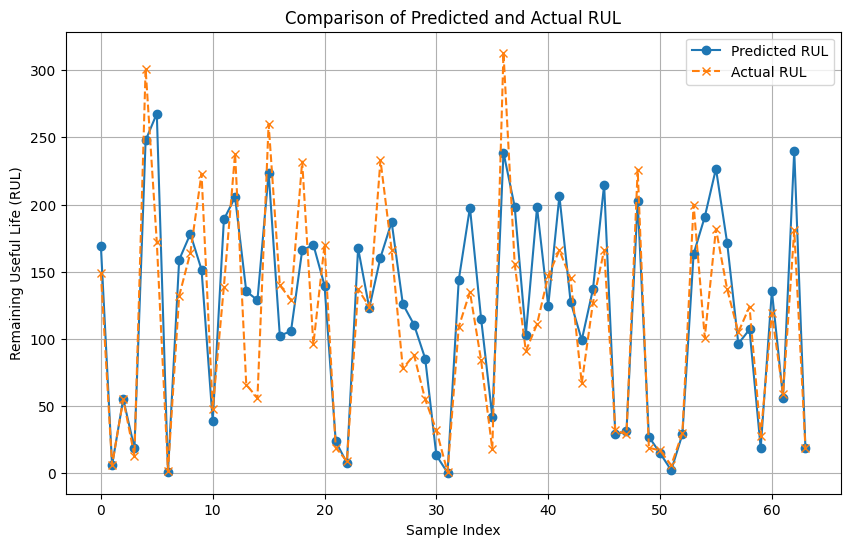

In [33]:
samples, targets = next(iter(validation_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
samples, targets = samples.to(device), targets.to(device)

model.eval()
with torch.no_grad():
    predictions = model(samples)

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

print(f'actual_predictions: {actual_predictions}')
print(f'actual_targets: {actual_targets}')

# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()

## Predict on a sample

In [34]:
samples.shape

torch.Size([64, 30, 21])

In [35]:
targets

tensor([0.2749, 0.0111, 0.1015, 0.0240, 0.5554, 0.3173, 0.0037, 0.2435, 0.3026,
        0.4114, 0.0886, 0.2565, 0.4391, 0.1218, 0.1033, 0.4797, 0.2583, 0.2380,
        0.4280, 0.1771, 0.3137, 0.0351, 0.0166, 0.2528, 0.2288, 0.4299, 0.3063,
        0.1439, 0.1624, 0.1015, 0.0590, 0.0018, 0.2011, 0.2491, 0.1550, 0.0332,
        0.5775, 0.2878, 0.1679, 0.2048, 0.2712, 0.3063, 0.2675, 0.1236, 0.2343,
        0.3063, 0.0590, 0.0535, 0.4170, 0.0351, 0.0314, 0.0111, 0.0554, 0.3690,
        0.1863, 0.3358, 0.2528, 0.1937, 0.2288, 0.0517, 0.2196, 0.1089, 0.3339,
        0.0351])

In [36]:
targets.shape

torch.Size([64])

In [37]:
idx = 0
sample = samples[idx].unsqueeze(0)
target = targets[idx].unsqueeze(0)

print(sample.shape)
print(target)

torch.Size([1, 30, 21])
tensor([0.2749])


In [38]:
model.eval()
with torch.no_grad():
    prediction = model(sample)

sample = sample.cpu()
target = target.cpu()
prediction = prediction.cpu()

print(f'Prediction: {prediction}')
print(f'Target: {target}')

rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

prediction = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_prediction = sum(prediction)/len(prediction)
actual_target = targets.numpy() * (rul_max - rul_min) + rul_min

# print(f'Giá trị RUL thực tế {actual_target}')
print(f'Giá trị RUL thực tế {actual_target[-1]}')
print(f'Giá trị RUL dự đoán {actual_prediction}')

Prediction: tensor([0.3125])
Target: tensor([0.2749])
Giá trị RUL thực tế 18.999999977648258
Giá trị RUL dự đoán 121.48381644854089


In [39]:
prediction

array([169.3487516 ,   6.02469123,  55.34622785,  18.70090355,
       247.76870012, 267.70946884,   0.96074983, 158.89875656,
       178.17010236, 151.54413384,  39.09588258, 188.90561533,
       205.51241785, 135.46850193, 128.85596576, 223.70606107,
       102.39656553, 105.82699659, 165.87335098, 170.09344685,
       139.75509912,  23.74438332,   7.7090326 , 167.57292247,
       122.94694313, 160.53046989, 187.01224184, 125.96378833,
       110.59673387,  85.38800102,  13.3114245 ,   0.43165486,
       143.84816891, 197.78673166, 115.05202344,  42.2199868 ,
       238.73403472, 198.54115093, 103.16775146, 197.89862251,
       124.56129214, 206.4720915 , 127.79456949,  99.16743138,
       136.90904617, 214.74077219,  28.91705365,  31.45204696,
       202.97496527,  27.17370186,  15.05195055,   2.25861184,
        29.07932527, 163.22127771, 190.85319781, 226.75084263,
       171.54911017,  96.43783247, 107.05492076,  18.89623199,
       135.77975136,  56.31654219, 240.14789444,  18.98

In [40]:
target

tensor([0.2749])